# Activity 2: Solid State Spis -- Cavity QED Digital Twin


## Prelab Activity

Read the background text for the [NV Center Lab](chapter:NV-Centers) to understand the basics of the experimental setup.

## Suggested Reading:
 * [E. Eisenach et al, Cavity-enhanced microwave readout of a solid-state spin sensor](https://www.nature.com/articles/s41467-021-21256-7)
 * [JF Barry et. al. Sensitivity optimization for NV-diamond magnetometry](https://https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.92.015004)
 * [ D. Fahey et. al., Steady-state microwave mode cooling with a diamond NV ensemble](https://https://arxiv.org/abs/2203.03462)
 * [ME Trusheim et. al. A Polariton-Stabilized Spin Clock
](https://arxiv.org/abs/2009.02427)



## Cavity-coupled quantum electrodynamic (QED) sensor

(Adapted from a lab initially developed by: Hanfeng Wang, Matthew E. Trusheim, and Dirk Englund)

Resonators for electromagnetic fields in the range of 1-100 GHz are essential in a range of quantum technologies, including superconducting quantum computers, microwave-optical quantum information interfaces, as well as sensors. Here, we consider microwave cavities coupled to ensembles of electron and nuclear spins associated with nitrogen vacancy (NV) centers in diamond. 

Following the discovery of coherent quantum dynamics of NV centers in the late 1990s, NV centers have emerged as leading quantum sensors for quantities ranging from electromagnetic fields to temperature, strain, rotation (gyroscopes), and have even been proposed for exotic schemes like dark matter detection. The key advantages of NV centers in sensing applications, over other electron spin systems, are their long coherence times and avaible optical polarization at room temperature.

Upon optical excitation, nonradiative decay through a spin-state-dependent intersystem crossing produces spin-state-dependent fluorescence contrast and polarize NV spin to the $m_s = 0$ ground state. A common method for NV spin readout relies on detecting this spin-state-dependent fluorescence. However, due to the low photon detection efficiency ($C \approx 0.015$) for the NV ensemble, the NV magnetic sensitivity is limited by the photon-shot-noise-limit.  It is then desirable to find an alternative method for NV spin readout.  

One such alternative is the use of electromagnetic cavity coupling.  In this case we use an electromagnetic cavity having a resonance near that of the NV spins which results in a strong interaction.  The interaction between the cavity mode and the NV spins can then be read out through observation of changes in the cavity properties, such as transmission and reflection of a probe signal coupled to the cavity.  

This approach was described in detail in lecture as well as in the [NV Center Lab Text](chapter:NV-Centers), so we refer you there first to review the experimental approach.  After that, in this simulation module, you will develop a digital twin simulation tool for the system.  Your model will include noise sources so that you can estimate realistic performance capabilities in practice.  

:::{figure-md} cavity-QED-setup
<img src="FIGURES/nv-center-cavity-qed-setup.png" alt="Experimental Setup" class="bg-primary mb-1" width="800px">

Experimental setup for studying quantum spins.
:::

## Observing Interaction Near the Anticrossing

Consider a case where we have a two-level system, such as a Nitrogen-Vacancy (NV) center, and an excitation, for example, a cavity mode. These two systems interact with each other when their frequencies are resonant. When their resonances cross, in the spectrum we will observe a phenomenon known as an [anti-crossing](https://en.wikipedia.org/wiki/Avoided_crossing), or avoided-crossing.  This occurs when the energy levels of the two systems approach each other closely but do not actually cross.

:::{figure-md} avoided-crossing
<img src="FIGURES/adiabatic-states-linear-field.png" alt="avoided crossing" class="bg-primary mb-1" width="800px">

Example of an avoided crossing of $\ket{\phi_1}$ and $\ket{\phi_2}$
:::

This effect is already captured in the model we developed in the [NV Center Lab Text](chapter:NV-Centers) for the reflectivity $\Gamma$ from the loop coupler interacting with the coupled cavity-spin system:

$$\Gamma = -1+\frac{\kappa_{c1}}{\frac{\kappa_c}{2}+j(\omega_d-\omega_c)+\frac{g^2}{\frac{\kappa_s}{2}+j(\omega_d-\omega_s)+\alpha}}$$

It can be useful to now consider detuning frequencies rather than absolute frequencies.  In particular we are interested in how $\Gamma$ behaves as a function of the detuning from the coupler frequency and the cavity frequency, $\omega_{dc} = \omega_d - \omega_c$ and the detuning from the spin frequency and the cavity frequency, $\omega_{sc} = \omega_s - \omega_c$.  When both the coupler and the spin frequencies approach the cavity freuqency you observe an anti-crossing. Note, however, that in our expression for $\Gamma$ we parameterize using $\omega_{dc}$ and $\omega_{ds} = \omega_d - \omega_s$ so it can be useful to rewrite $\omega_{ds} = \omega_{dc} - \omega_{sc}$.  

In the following code we provide an example calculation of $\Gamma$ in Python.  We also provide sliders for adjusting the values of each of the important parameters such as coupling strength and the $k$ coefficients.  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
%matplotlib inline

@widgets.interact_manual(
    g0_in=(0.01, 1.),kc0_in=(1., 1000.),kc1_in=(1., 1000.),ks_in=(1., 1000.))
def runFunc(g0_in=0.01, kc0_in = 70, kc1_in = 111, ks_in = 308):
    kc0 = 2*np.pi*kc0_in; #kHz  Cavity linewidth
    kc1 = 2*np.pi*kc1_in; #kHz   Cavity-loop coupling (output coupling)

    ks = 2*np.pi*ks_in; #kHz  Spin coherence time


    density_NVs = 5; #PPM Density of NV centers in the diamond, given in ppm
    diamondDensity = 1.76e29; # atoms/m^3 Atomic density of diamond
    density_NVs_SI = density_NVs*1e-6*diamondDensity; # NV/m^3

    diamond_sample_dim_x=3e-3; # m Diamond spatial dimensions, assuming cuboid
    diamond_sample_dim_y=3e-3; # m
    diamond_sample_dim_z=0.5e-3; # m
    diamond_sample_volume = diamond_sample_dim_x*diamond_sample_dim_y*diamond_sample_dim_z;

    N_NVs= density_NVs_SI*diamond_sample_volume ; # the number of NVs in the diamond

    g0 = g0_in*1e-3; #kHz   Coupling strength for single spin, see referenced papers

    geff = g0*np.sqrt(N_NVs); # Total coupling scales as sqrt(N)


    kc = kc0 + kc1; # Total cavity loss

    xnum = 101; # number of points to plot in x
    ynum = 121;

    # initialize sweep parameters
    wdc = np.linspace(-0.8,0.8,num=xnum)*1e3*2*np.pi;  #kHz  Detuning of the probe frequency and cavity frequency
    wsc = np.linspace(-7.4,7.4,num=ynum)*1e3*2*np.pi;  #kHz  Detuning of the spin frequency and cavity frequency

    # initialize output ararys
    inphaseOut = np.zeros((xnum,ynum));
    quadratureOut = np.zeros((xnum,ynum));

    for ii in range(xnum):

      for jj in range(ynum):

        wds = wdc[ii]-wsc[jj]; #drive-spin detuning

        # Cavity reflection signal from references
        refOutput = -1 + kc1/(kc/2+1j*wdc[ii]+pow(geff,2)/(ks/2+1j*wds));
        inphaseOut[ii][jj] = np.real(refOutput); # In-phase part of the cavity signal
        quadratureOut[ii][jj] = np.imag(refOutput);  # Quadrature part of the cavity signal

    y, x = np.meshgrid(np.linspace(-7.4,7.4,num=ynum), np.linspace(-0.8,0.8,num=xnum),)
    fig, figAxes = plt.subplots(2,2,sharex='all', sharey='all')
    ax1 = figAxes[0,0];
    ax2 = figAxes[0,1];
    ax3 = figAxes[1,0];
    ax4 = figAxes[1,1];


    c = ax1.pcolormesh(y, x, quadratureOut)
    ax1.set_title(r'Q$ = \text{Im}[\Gamma]$')
    #ax1.set_xlabel('fsc (MHz)')
    ax1.set_ylabel('fdc (MHz)')
    fig.colorbar(c, ax=ax1)

    c = ax2.pcolormesh(y, x, inphaseOut)
    ax2.set_title(r'I$ = \text{Re}[\Gamma]$')
    #ax2.set_xlabel('fsc (MHz)')
    #ax2.set_ylabel('fdc (MHz)')
    fig.colorbar(c, ax=ax2)

    c = ax3.pcolormesh(y, x, np.sqrt(pow(quadratureOut,2)+pow(inphaseOut,2)))
    ax3.set_title(r'P$ = |\Gamma|$')
    ax3.set_xlabel('fsc (MHz)')
    ax3.set_ylabel('fdc (MHz)')
    fig.colorbar(c, ax=ax3)

    c = ax4.pcolormesh(y, x, np.arctan( np.divide(quadratureOut,inphaseOut)))
    ax4.set_title(r'$\phi = \arg(\Gamma)$')
    ax4.set_xlabel('fsc (MHz)')
    #ax4.set_ylabel('fdc (MHz)')
    fig.colorbar(c, ax=ax4)

    plt.show()


interactive(children=(FloatSlider(value=0.01, description='g0_in', max=1.0, min=0.01), FloatSlider(value=70.0,…

## Exercise 1

1. Discuss the results. Are there any differences between the in-phase, quadrature, magnitude, and phase componenets of $\Gamma$ that stand out?  Could these have an impact in analysis when using this as a sensor?
2. Adjust each of the values of $k_{c1}$, $k_c$, $k_s$ and $g$.  For each variable, describe how it impacts the results.  How might each play a role in the use of the cavity-coupled spin setup as a sensor?  

## Noise Model

Now we have a model for $\Gamma$ but it is missing noise.  We need to parameterize the noise.  

In the code below we consider realistic noise sources as a function of frequency

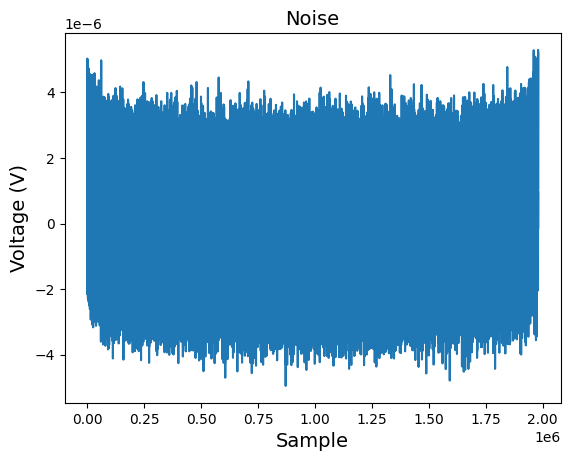

In [5]:
length = 2000000  # Length of the signal
fs = 200e3      # Sampling frequency in Hz


# -- Adding Shot-Noise (White Noise)

#white noise -- constant across all frequencies
white_noise = np.random.randn(length)*1e-6

# -- Adding Power Line Noise -- 

#Sinusoidal noise from building power -- these are at harmonics of 60 Hz for us
t = np.arange(length) / fs
sine_wave = 0
for ii in range(10):
    sine_wave = sine_wave + 1e-7* np.sin(2 * np.pi * 60 * t * (ii+1)) * 1/2**ii

#Now we add this into our white noise and take the fft which gives the noise as a function of freuqency
fft_result1 = np.fft.fft(white_noise+sine_wave)

# -- Adding Flicker Noise (1/f noise) -- 

#Here we develop a frequency axis based on the time sampling:
frequencies = np.fft.fftfreq(length, d=1/fs)
frequencies[0] = 1e-6  # Avoid division by zero

#Develop a scaled inverse frequency noise source for 1/f noise:
scale_factor = 1 / np.sqrt(np.abs(frequencies))
fft_result2 = scale_factor

#And add that back into our total noise in the frequency domain:
modified_fft = (fft_result1 + fft_result2*1e-1);

#Now bring this back to time for the total noise (of course keeping only the real part):
total_noise = np.fft.ifft(modified_fft).real

#Remove the DC component as well:
total_noise = total_noise - np.mean(total_noise)

plt.plot(total_noise[10000:2000000-10000])
plt.title('Noise', fontsize=14)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Voltage (V)', fontsize=14)
plt.show()

Now we plot the total noise as a function of frequency as well:

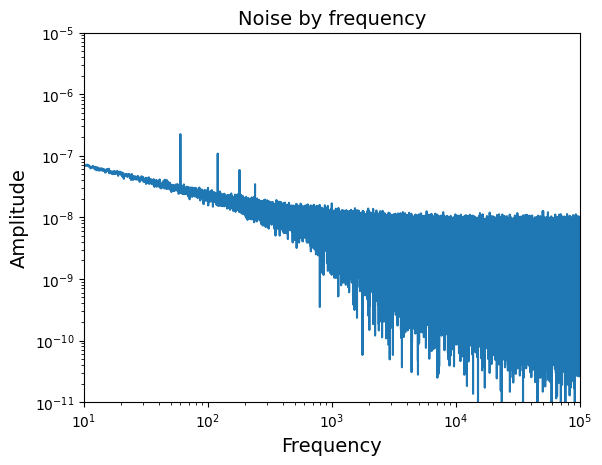

In [6]:
from scipy.signal import periodogram
frequencies, psd = periodogram(total_noise, fs)
plt.plot(frequencies, np.sqrt(psd))
plt.xscale("log")
plt.yscale("log")
plt.ylim([1e-11,1e-5])
plt.xlim([1e1,1e5])
plt.title('Noise by frequency', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Amplitude', fontsize=14);

## Exercise 2

1. In the code above, examine the noise source contributions one by one to see how they contribute to the total noise individually. Discuss your findings. Pay particular attention to what noise sources are dominant across the different frequency ranges.
2. Based on the findings from (1) and that you perform measurements near ~2.87 GHz, which noise source dominates?  Can you safely ignore the other sources of noise in this frequency range?  

## Exercise 3

Now we have the signal and noise model. We provide a perfect plot of the signal below. Please generate one with the noise incorporated and plot it below the perfect signal for comparison.  You can choose the weight of the noise arbitrarily for now, but this could be refined through comparison to experiment.  You might discuss with the experimental team to get an idea of the noise amplitude they observe.  


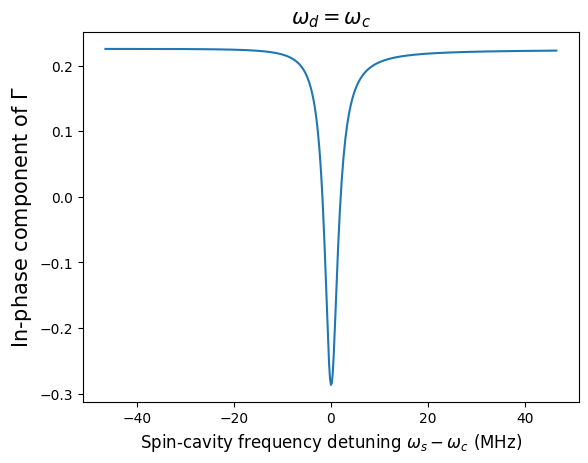

In [7]:
# Part 1
# Let's consider a 1D plot first.

g0_in=0.01
kc0_in = 70
kc1_in = 111
ks_in = 308
kc0 = 2*np.pi*kc0_in; #kHz  Cavity linewidth
kc1 = 2*np.pi*kc1_in; #kHz   Cavity-loop coupling (output coupling)

ks = 2*np.pi*ks_in; #kHz  Spin coherence time

density_NVs = 5; #PPM Density of NV centers in the diamond, given in ppm
diamondDensity = 1.76e29; # atoms/m^3 Atomic density of diamond
density_NVs_SI = density_NVs*1e-6*diamondDensity; # NV/m^3

diamond_sample_dim_x=3e-3; # m Diamond spatial dimensions, assuming cuboid
diamond_sample_dim_y=3e-3; # m
diamond_sample_dim_z=0.5e-3; # m
diamond_sample_volume = diamond_sample_dim_x*diamond_sample_dim_y*diamond_sample_dim_z;

N_NVs= density_NVs_SI*diamond_sample_volume ; # the number of NVs in the diamond

g0 = g0_in*1e-3; #kHz   Coupling strength for single spin, see referenced papers

geff = g0*np.sqrt(N_NVs); # Total coupling scales as sqrt(N)


kc = kc0 + kc1; # Total cavity loss

xnum = 501; # number of points to plot in x
ynum = 501;

# initialize sweep parameters
wdc = np.linspace(-0.8,0.8,num=xnum)*1e3*2*np.pi;  #kHz  Detuning of the probe frequency and cavity frequency
wsc = np.linspace(-7.4,7.4,num=ynum)*1e3*2*np.pi;  #kHz  Detuning of the spin frequency and cavity frequency

# initialize output ararys
inphaseOut = np.zeros((xnum,ynum));
quadratureOut = np.zeros((xnum,ynum));

for ii in range(xnum):

  for jj in range(ynum):

    wds = wdc[ii]-wsc[jj]; #spin-cavity detuning

    # Cavity reflection signal from references
    refOutput = -1 + kc1/(kc/2+1j*wdc[ii]+pow(geff,2)/(ks/2+1j*wds));
    inphaseOut[ii][jj] = np.real(refOutput); # In-phase part of the cavity signal
    quadratureOut[ii][jj] = np.imag(refOutput);  # Quadrature part of the cavity signal

plt.plot(wsc/1000,inphaseOut[251][:])
plt.title(r'$\omega_{d} = \omega_{c}$', fontsize=15)
plt.xlabel(r'Spin-cavity frequency detuning $\omega_{s} - \omega_{c}$ (MHz)', fontsize=12)
plt.ylabel(r'In-phase component of $\Gamma$', fontsize=15);

# Part 2
# Now you have a perfect signal, could you add noise here?
## Please add your code here

## Exercise 4
Now assume we have a test field $B_t$. Could you emulate $B_t$ in the digital twin? Approximate the minimum test field $B_t$ you can measure in the digital twin choosing some noise level.  

Hint: Look at how the inphase and quadrature components of $\Gamma$ change with magnetic field (which shifts the spin frequency). Which component of $\Gamma$ is more sensitive to magnetic field near zero detuning? When does the change in underlying signal outweigh noise?

In [8]:
## Add your code here

## Taking Things Further: The Nonlinear Regime

While the above results provide a good understanding of the anti-crossing feature in NV-cavity coupling, this knowledge alone is technically not sufficient to provide a complete picture of the system. Let's delve deeper into the issue.

In the schematic of the setup, there are actually three components: the NV center, the cavity mode, and an antenna designed to detect the cavity mode. It is crucial to couple the antenna with the cavity mode to facilitate detection. This raises a question:

Why can't the antenna couple with the NV system directly?

The answer is that it indeed can couple with the NV system, but only when the input power to the antenna is sufficiently high. Consequently, we are dealing with a tripartite system. To analyze this system, we employ a semiclassical model to solve the Maxwell-Bloch equations for the hybrid system. Here we do not expand the details for the derivation about the Maxwell-Bloch equations because it is too complicated and beyond the scope of our course. If you are really interested in the whole process, please ask the TA.

However, we do provide code that simulates the results of this analysis below for your reference.  In addition to this nonlinearity, we also account for all three hyperfine transitions that are present in the actual experiment.  This code could, in combination with the noise models you developed above, could be useful for developing a more accurate simulation of the system in the lab. 

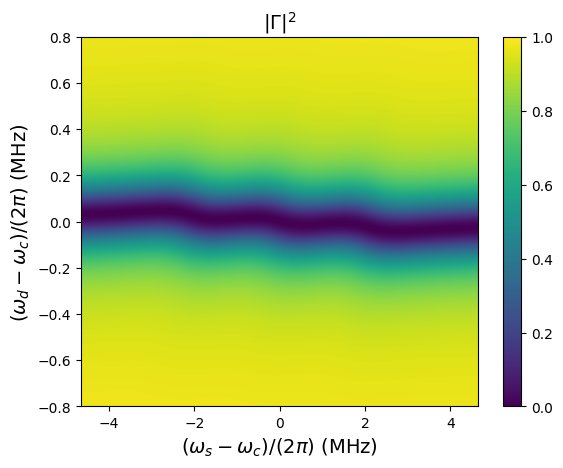

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and Parameters
Gamma = 330e3  # Inhomogeneous linewidth
gammao = 33e3  # Optical polarization rate
gamma = 2e3    # Homogeneous linewidth

kc1 = 130e3 # Intrinsic cavity linewidth
kc = kc1 + 130e3  # Total cavity linewidth
gs = 0.019 # Single spin coupling strength
Power = -10  # Input MW power
alpha2 = 10**(Power/10) * 1e-3 / (6.626e-34 * 2.87e9 * kc1)

geff = 0.2e6  # Total coupling strength

omega = 0

wdc = np.linspace(-0.8, 0.8, 1001) * 1e6
wsc = np.linspace(-4.65, 4.65, 1001) * 1e6

# Initialize array for results
ref = np.zeros((len(wdc), len(wsc)), dtype=complex)

# Main calculation loop
for ii in range(len(wdc)):
    for jj in range(len(wsc)):
        wds = wdc[ii] - wsc[jj]
        integ1 = 2 * ((gamma + gammao) + (gamma + gammao) * Gamma / np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2) - 2j * wds) / \
                ((Gamma + np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2))**2 + 4 * wds**2)
        integ2 = 2 * ((gamma + gammao) + (gamma + gammao) * Gamma / np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2) - 2j * (wds + 2.1e6)) / \
                ((Gamma + np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2))**2 + 4 * (wds + 2.1e6)**2)
        integ3 = 2 * ((gamma + gammao) + (gamma + gammao) * Gamma / np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2) - 2j * (wds - 2.1e6)) / \
                ((Gamma + np.sqrt(4 * 3 * gs**2 * alpha2 / gammao * (gammao + gamma) + (gammao + gamma)**2))**2 + 4 * (wds - 2.1e6)**2)
        integ = integ1 + integ2 + integ3
        ref[ii, jj] = -1 + kc1 / (kc / 2 + 1j * wdc[ii] + geff**2 * integ)

# Plotting
plt.figure(10)
plt.imshow(np.abs(ref)**2, extent=[wsc[0] / 1e6, wsc[-1] / 1e6, wdc[0] / 1e6, wdc[-1] / 1e6], aspect='auto', origin='lower')
plt.colorbar()
plt.clim(0, 1)

plt.xlabel(r'$(\omega_s-\omega_c)/(2\pi)$ (MHz)', fontsize=14)
plt.ylabel(r'$(\omega_d-\omega_c)/(2\pi)$ (MHz)', fontsize=14)
plt.title(r'$|\Gamma|^2$', fontsize=14)

plt.show()

## Minimum detectable magnetic field



Here is the sensitivity analysis for cavity-coupled sensor. In the ideal case, the spin-projection-limit sensitivity is propotional to the inverse of the square root of the number of spins (N). However, the NV decoherence time and dephasing time will decrease during the increase of the NV number. Therefore, the sensivitity will decrease sharply in the large-N regime. The script below calculated the spin-projection-limit sensitivity and photon-shot-noise-limit with different number of spins.

The script below also include the cavity-coupled spin sensor. The scale of the sensitivity in the low-N regime is linear with the 1/N rather than 1/sqrt(N), which offers the possibility for this sensor to go below the spin-projection-limit sensitivity.

Text(0, 0.5, 'Sensitivity (T/$\\sqrt{Hz}$)')

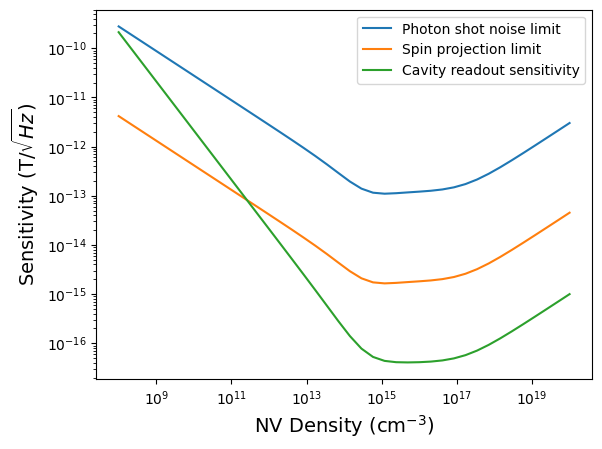

In [10]:
Delta = 2e6;
f = 0.1;

Sphi = 1e-9; # phase noise

Q = 3e4;  # Quality factor

hbar = 1.05e-34;

gs = 2;

muB = 9.27e-24;

rho = np.logspace(8,20,40)*1e6;

Tc = 1/3.3e-19/(rho*(0.95/0.05));

T2c = 300e-6;

T2 = 1/(1/T2c+1/Tc);

mu0 = 4*np.pi*1e-7;

C = 0.015;

etaB = 8 * pow((hbar/gs/muB),3) * Delta/np.pi/Q/T2 * Sphi * 1/mu0/hbar/rho *1/f * np.exp(pow((T2/T2c),3))* np.exp(T2/Tc)* np.sqrt(1+1e-6/T2);

eta = hbar/muB/gs * np.pi * np.exp(pow((T2/T2c),3))/C/np.sqrt(rho*T2) * np.exp(T2/Tc) * np.sqrt(1+1e-6/T2);

eta_proj = hbar/muB/gs * np.pi * np.exp(pow((T2/T2c),3))/np.sqrt(rho*T2) * np.exp(T2/Tc) * np.sqrt(1+1e-6/T2);

fig,ax = plt.subplots()

ax.loglog(rho/1e6,eta*1/np.sqrt(3e-3*3e-3*0.5e-3),label='Photon shot noise limit')

ax.loglog(rho/1e6,eta_proj*1/np.sqrt(3e-3*3e-3*0.5e-3),label='Spin projection limit')

ax.loglog(rho/1e6,etaB,label='Cavity readout sensitivity')

ax.legend()

ax.set_xlabel(r'NV Density (cm$^{-3}$)',fontsize=14)
ax.set_ylabel(r'Sensitivity (T/$\sqrt{Hz}$)',fontsize=14)